## Описание проекта


# 1. Подготовка

In [1]:
# загрузка библитек
# осуществление операций в массивом данных
import pandas as pd
import numpy as np
# модели
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
# разделение выборки, поиск оптимальных гиперпараметров модели
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
# проверка (не)стационарности временного ряда
from statsmodels.tsa.stattools import adfuller
# графическая иллюстрация данных
import matplotlib.pyplot as plt
# изменение темы диаграммы
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# загрузка данных
taxi = pd.read_csv('taxi.csv', parse_dates=[0], index_col='datetime')

In [3]:
# вывод первых пяти наблюдений
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# вывод общей информации по выборочной совокупности
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


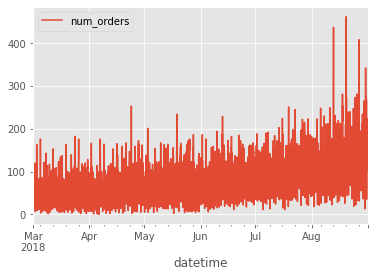

In [5]:
# графическая иллюстрация динамики суммарного количества заказов такси в течение одного часа
taxi.resample('1H').sum().plot()

- наблюдается восходящий тренд. Временной ряд является нестационарным.

In [6]:
# численная проверка (не)стационарности временного ряда (с константой и трендом)
adfuller(x=taxi['num_orders'].asfreq(freq='1H'),maxlag=1, regression='ct')

(-37.19854091683216,
 0.0,
 1,
 4414,
 {'1%': -3.9608224574767696,
  '5%': -3.411485117682747,
  '10%': -3.1276359742557323},
 30876.529590578197)

- согласно p-значению (равное нулю), нулевую гипотезу о нестационарности не отклоняем. Временной ряд по количеству заказов является нестационарным.

In [7]:
# Формирование выборки по суммарному количеству заказов в течение одного часа
taxi_by_hour = taxi.resample('1H').sum()

In [8]:
# Определим функцию, которая выделяет дополнительные признаки:
# час, день недели, день месяца, месяц, лаг количества заказов такси
def make_features(data, max_lag):
    '''
    Функция сортирует данные по индексам. 
    Далее, формирует 5 выделяет дополнительных переменных:
    час, день недели, день месяца, месяц, лаг количества заказов.
    В итоговом массиве данных удаляются пропущенные наблюдения.
    '''
    # сортировка данных по индексам
    data.sort_index(inplace=True)
    # выделение часа
    data['hour'] = data.index.hour
    # выделение дня недели
    data['dayofweek'] = data.index.dayofweek
    # выделение дня месяца
    data['dayofmonth'] = data.index.day
    # выделение месяца
    data['month'] = data.index.month
    # выделение лага количества заказов такси
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # возвращаем итоговый массив данных с удалением пропущенных наблюдений
    return data.dropna(inplace=True)

In [9]:
# При апробации функции make_features воспользуемся исключениями
try:
    make_features(taxi_by_hour, max_lag=1)
except:
    print('Возникла ошибка')
else:
    print('Преобразование данных выполнено')

Преобразование данных выполнено


In [10]:
# вывод первых пяти наблюдений выборочной совокупности с учетом дополнительных признаков.
taxi_by_hour.head()

,num_orders,hour,dayofweek,dayofmonth,month,lag_1
datetime,,,,,,
2018-03-01 01:00:00,85,1,3,1,3,124.0
2018-03-01 02:00:00,71,2,3,1,3,85.0
2018-03-01 03:00:00,66,3,3,1,3,71.0
2018-03-01 04:00:00,43,4,3,1,3,66.0
2018-03-01 05:00:00,6,5,3,1,3,43.0


### Промежуточные итоги
- исходные статистические данные `taxi` имеют 10-ти минутную периодичность.
- рассматриваемый период: 1 марта - 31 августа 2018 года.
- временной ряд по количеству заказов такси является нестационарным.
- выборка `taxi_by_hour` содержит информацию по суммарному количеству заказов в течение одного часа
- к исходным данным добавили 5 переменных: час `hour`, день недели `dayofweek`, день месяца `dayofmonth`, месяц `month`, смещение на 1 час назад `lag_1`.

# 2. Анализ

Просмотрим на динамику временного ряда графически.

In [11]:
# Определим функцию, которая иллюстрирует суммарное количество заказов 
# в зависимости от частоты времени
def plot_by_freq(data, freq):
    '''
    Функция строит диаграммы суммарного количества заказов 
    в зависимости от указанной частоты времени.
    data - массив данных
    freq - частота времени: минута, час, день, месяц
    '''
    plt.figure(figsize=(8,4))
    plt.ylabel('количество_заказов')
    # построим суммарное число заказов в зависимости от указанной периодичности
    data.groupby(freq)['num_orders'].mean().plot()

In [12]:
# определим словарь временной периодичности заказов такси
freq_dict = {'час':'hour',
             'день_недели':'dayofweek',
             'день_месяца':'dayofmonth',
             'месяц':'month'}

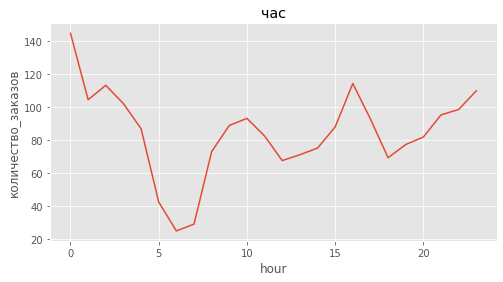

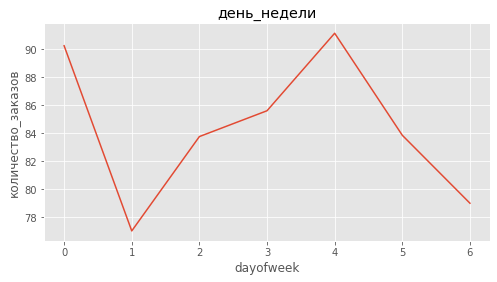

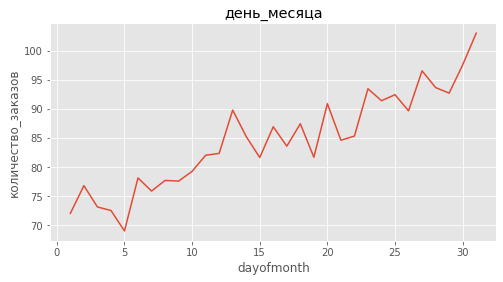

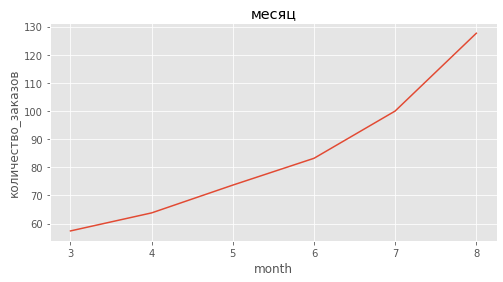

In [13]:
# Через цикл for 
for freq_name, freq_format in freq_dict.items():
    # для каждой периодичности построим суммарное число заказов такси
    plot_by_freq(taxi_by_hour, freq_format)
    # определим заголовок диаграммы
    plt.title(freq_name)
    # отображение диаграммы
    plt.show()

Суммарное число заказов такси в течение часа:
- **час:** наибольшее значение достигает в полночь. Наименьшее значение в 06:00 утра. После обеда больше заказов, чем до 12:00 часов дня.
- **день недели:** в понедельник и четверг имеем наибольшее число заказов. Меньше всего заказов наблюдается во вторник.
- **день месяца:** на начало месяца около 74 заказов. Затем повышается число заказов такси, достигая максимального значения к концу месяца - около 120 заказов.
- **месяц:** Весной меньше заказов, чем летом. Это может объясняться пляжным сезоном. Также повышение количества заказов в августе может объясняться перелетами новых студентов, мигрантов для трудоустройства.

# 3. Обучение

In [14]:
# выделение матрицы признаков
features = taxi_by_hour.drop(labels='num_orders', axis=1)
# выделение вектора целевых значений суммарного количества заказов в течение одного часа
target = taxi_by_hour['num_orders']

In [15]:
# разделение матрицы признаков и вектора целевых значений на тренировочное и тестовое множества
features_train, features_test, target_train, target_test = train_test_split(features,target, shuffle=False)

In [16]:
# Определим функцию, которая обучает модели
def train(model, features_train, target_train, features_predict=None, target_predict=None, grid_params=None, cv=5):
    '''
    model: модель обучения (1) 'dummy': простейшая модель на основе среднего значения, 
                           (2) 'linear': линейная модель, 
                           (3) 'random_forest': модель случайного леса.
    features_train: матрица признаков тренировочного множества
    target_train: вектор целевых значений тренировочного множеств
    features_predict: матрица признаков на котором вычисляем прогноз
    target_predict: вектор фактических значений с которым сравниваем прогноз
    grid_params: множество гиперпараметров для моделей
    cv: количество блоков кросс-валидации
    '''
    # для каждого типа моделей вычислим прогноз количества такси
    # (1) простейшая (наивная) модель
    if model == 'dummy':
        dum = DummyRegressor(strategy='mean').fit(features_train, target_train)
        pred = dum.predict(features_predict)
    # (2) модель линейной регрессии
    elif model == 'linear':
        lin = LinearRegression(n_jobs=-1).fit(features_train, target_train)
        pred = lin.predict(features_predict)
    # (3) модель случайного леса
    elif model == 'random_forest':
        rf = RandomForestRegressor(random_state=42)
        # определение множества гиперпараметров
        grid = GridSearchCV(estimator=rf, param_grid=grid_params,cv=cv, 
                            n_jobs=-1, scoring='neg_mean_squared_error')
        grid_rf = grid.fit(features_train, target_train)
        # прогнозируем суммарное число заказов на следующий час на основе наилучшей модели случайного леса
        pred = grid_rf.best_estimator_.predict(features_predict)
        # отображение (гипер)параметров наилучшей модели случайного леса
        print('-' * len('Наилучшая модель случайного леса'))
        print('Наилучшая модель случайного леса:')
        print(grid_rf.best_estimator_)
    # вывод квадрата среднеквадратической ошибки
    return mean_squared_error(pred, target_predict) ** 0.5

In [17]:
# определим словарь моделей
models_dict = {'дамми_среднее':'dummy',
               'линейная_модель':'linear',
               'случайный_лес':'random_forest'}

In [18]:
# определим множество гиперпараметров, 
# чтобы определить лучшую (с точки зрения среднеквадратической ошибки) модель случайного леса
rf_params = {'n_estimators':np.arange(100,131,10),'max_depth':np.arange(10,31,10)}

In [19]:
# Через цикл for для трех моделей вычислим прогноз суммарного количества заказов такси на следующий час.
# Прогноз вычисляется на основе тренировочного множества.
# Итоговый параметр - квадрат среднеквадратической ошибки.
# Воспользуемся исключениями.
try:
    rmse_train = []
    for model_name, model_type in models_dict.items():
        model = train(model=model_type, features_train=features_train, target_train=target_train,
                      features_predict=features_train, target_predict=target_train, grid_params=rf_params)
        rmse_train.append(model)
except:
    print('Возникла ошибка')
else:
    print('-' * len('Квадрат среднеквадратической ошибки (тренировочное множество)'))
    # Отображение таблицы, которая содержит квадрат средеквадратической ошибки на основе тренировочного множества
    print('Квадрат среднеквадратической ошибки (тренировочное множество):')
    print(pd.DataFrame(data=dict(RMSE_train=rmse_train), index=models_dict.keys()) )

--------------------------------
Наилучшая модель случайного леса:
RandomForestRegressor(max_depth=30, n_estimators=120, random_state=42)
-------------------------------------------------------------
Квадрат среднеквадратической ошибки (тренировочное множество):
                 RMSE_train
дамми_среднее     34.767087
линейная_модель   28.621590
случайный_лес      7.721534


### Промежуточные итоги
- определили функцию `train`, которая вычисляет квадрат среднеквадратической ошибки (`rmse`).
- наилучшая модель случайного леса имеет 120 деревьев `n_estimators=120`. У деревьев максимальная глубина составляет 30 `max_depth=30`.
- `rmse`: у модели случайного леса (7.72). Далее, у модели линейной регресси (28.62). У фиктивной модели (34.77). 

# 4. Тестирование

In [20]:
# Аналогично, через цикл for для трех моделей вычислим прогноз суммарного кол-ва заказов такси на следующий час.
# В данном случае, прогноз вычисляется на основе тестового множества.
# Итоговый параметр - квадрат среднеквадратической ошибки.
# Воспользуемся исключениями.
try:
    rmse_test = []
    for model_name, model_type in models_dict.items():
        model = train(model=model_type, features_train=features_train, target_train=target_train,
                      features_predict=features_test, target_predict=target_test, grid_params=rf_params)
        rmse_test.append(model)
except:
    print('Возникла ошибка')
else:
    # Отображение таблицы, которая содержит квадрат среднеквадратической ошибки на основе тестового множества
    print('-' * len('Квадрат среднеквадратической ошибки (тестовое множество):'))
    print('Квадрат среднеквадратической ошибки (тестовое множество):')
    print(pd.DataFrame(data=dict(RMSE_test=rmse_test), index=models_dict.keys()) )

--------------------------------
Наилучшая модель случайного леса:
RandomForestRegressor(max_depth=30, n_estimators=120, random_state=42)
---------------------------------------------------------
Квадрат среднеквадратической ошибки (тестовое множество):
                 RMSE_test
дамми_среднее    71.121425
линейная_модель  45.815218
случайный_лес    45.383194


### Промежуточные итоги
- Вычислили прогноз суммарного количества такси на следующий час на основе тестового множества.
- `rmse` для трех моделей: модель случайного леса (45.38), модель линейной регрессии (45.81), фиктивной модели (71.12). 